In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

import warnings
warnings.filterwarnings('ignore')

# Importing Data

In [3]:
df=pd.read_csv("df.csv")

In [4]:
df

,Store,CompetitionDistance,Promo2,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StateHoliday_EasterHoliday,StateHoliday_None,...,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None,Assortment,IsWeekend,Promo_SchoolHoliday,CompetitionDist_Bin
0,1,0.264831,0,0.666667,5263.0,1.0,1.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0.0,2
1,1,0.264831,0,0.500000,5020.0,1.0,1.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0.0,2
2,1,0.264831,0,0.333333,4782.0,1.0,1.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0.0,2
3,1,0.264831,0,0.166667,5011.0,1.0,1.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0.0,2
4,1,0.264831,0,0.000000,6102.0,1.0,1.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,1115,0.488347,1,0.000000,6905.0,1.0,1.0,0.0,0,1,...,1,0,1,0,1,0,1,0,0.0,3
844388,1115,0.488347,1,0.833333,4771.0,1.0,0.0,0.0,0,1,...,1,0,1,0,1,0,1,1,0.0,3
844389,1115,0.488347,1,0.666667,4540.0,1.0,0.0,0.0,0,1,...,1,0,1,0,1,0,1,0,0.0,3
844390,1115,0.488347,1,0.500000,4297.0,1.0,0.0,0.0,0,1,...,1,0,1,0,1,0,1,0,0.0,3


# Visualize the Time Series

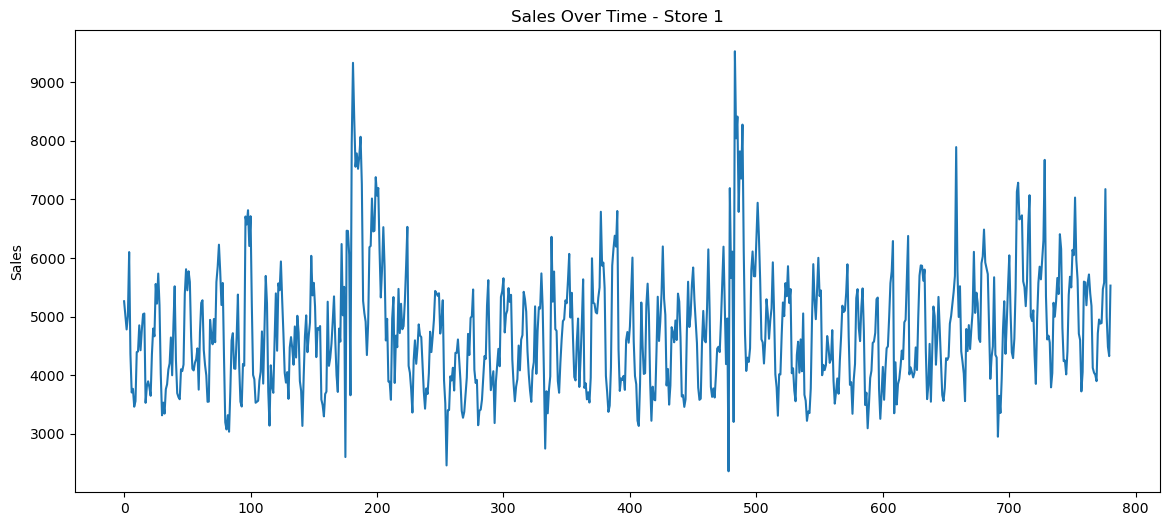

In [5]:
import matplotlib.pyplot as plt

# Filter for one store (e.g., Store 1)
store_df = df[df['Store'] == 1]

# Plot
store_df['Sales'].plot(figsize=(14, 6), title='Sales Over Time - Store 1')
plt.ylabel('Sales')
plt.show()

# Decompose Time Series

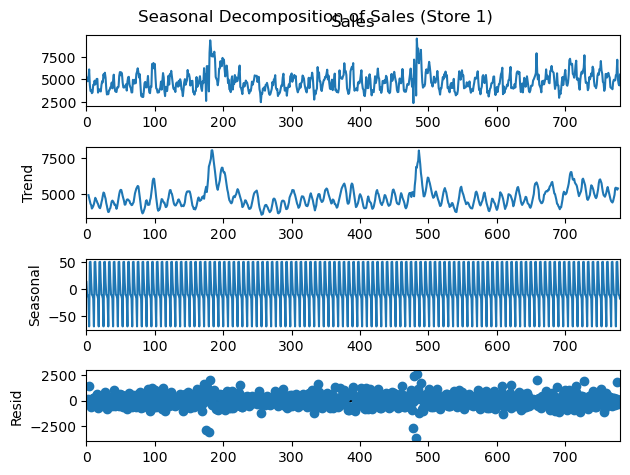

In [6]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the sales series (Store 1)
result = seasonal_decompose(store_df['Sales'], model='additive', period=7)
result.plot()
plt.suptitle("Seasonal Decomposition of Sales (Store 1)")
plt.show()

# Autocorrelation Analysis

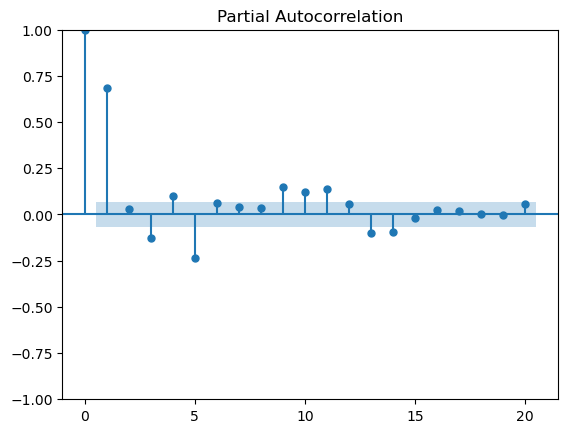

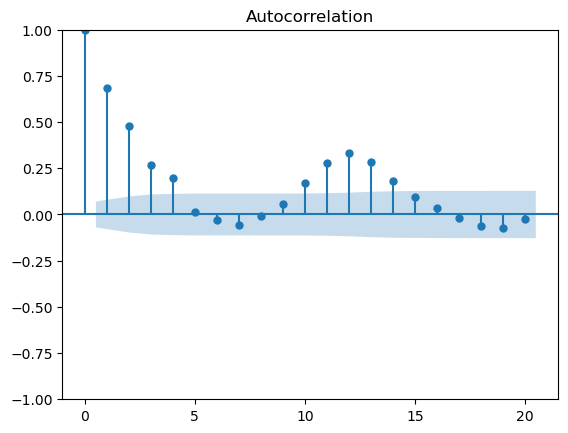

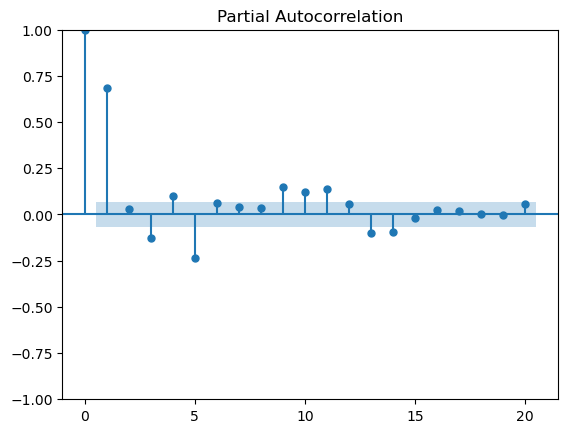

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(store_df['Sales'].dropna(), lags=20)
plot_pacf(store_df['Sales'].dropna(), lags=20)

Insights:

These plots visualize the autocorrelation (ACF) and partial autocorrelation (PACF) of Store 1’s sales data up to 20 lags.

They help identify the appropriate values for ARIMA parameters:

ACF suggests the order of the MA (q) term.

PACF suggests the order of the AR (p) term.

Significant spikes outside the confidence band indicate relevant lags for modeling.

# Fit SARIMA & ARIMA model

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(store_df['Sales'], order=(1,1,1), seasonal_order=(0,1,1,7))
results = model.fit(disp=False)

Insights:

This code fits a SARIMA model to Store 1’s sales data with the parameters:

(1,1,1) for ARIMA (p,d,q): autoregression, differencing, and moving average,

(0,1,1,7) for seasonal components with weekly seasonality (7 days).

The model captures both trend and seasonal patterns and is now ready for forecasting future sales.

# Prophet Forecasting

In [9]:
forecast = results.predict(start=store_df.index[-30], end=store_df.index[-1])
forecast_df = pd.DataFrame({'Date': forecast.index, 'Forecast': forecast.values})
store_df_reset = store_df.reset_index().rename(columns={'index': 'Date'})
store_df_merged = pd.merge(store_df_reset, forecast_df, on='Date', how='left')

# Evaluate Forecast Accuracy

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
eval_df = store_df_merged.dropna(subset=['Forecast'])

mae = mean_absolute_error(eval_df['Sales'], eval_df['Forecast'])
rmse = mean_squared_error(eval_df['Sales'], eval_df['Forecast'])

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 517.12, RMSE: 483738.06


Insights:

This code evaluates the forecast accuracy using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) between actual and predicted sales.

Lower values of MAE and RMSE indicate better model performance, with RMSE penalizing larger errors more heavily than MAE.

# Export Forecast

In [11]:
store_df_merged.to_csv('store1_forecast.csv', index=False)

# Serialize SARIMA Model with pickle


In [12]:
import pickle

# Save the SARIMA model to a file
with open("sarima_store1_model.pkl", "wb") as f:
    pickle.dump(results, f)

print("✅ SARIMA model saved as 'sarima_store1_model.pkl'")

✅ SARIMA model saved as 'sarima_store1_model.pkl'


In [13]:
df.to_csv('dff.csv', index=False)